In [1]:
from moseq2_detectron_extract.io.session import Session
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns

from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features
from moseq2_detectron_extract.proc.hha_encode import getHHA, getCameraParam
from scipy import signal
from scipy import ndimage
import math
from mpl_toolkits.axes_grid1 import ImageGrid
import itertools

In [2]:
session = Session(r"E:\moseq_raw_data\detectron2_testing_full\session_20200915132521\depth.dat")
first_frame, bground_im, roi, true_depth = session.find_roi()

In [3]:
def plot_frames(frames, idxs, cols=5, fig_size=(20,20), vmin=0, vmax=100, features=None):
    cols = int(cols)
    rows = int(np.ceil(frames.shape[0] / cols))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=fig_size)
    
    for i, ax in enumerate(axs.flat):
        ax.imshow(frames[i], vmin=vmin, vmax=vmax)
        if features is not None:
            feat = features[i]
            # draw the centroid as a point
            ax.scatter(feat['centroid'][0], feat['centroid'][1], c='r')
            # draw the orientation as an arrow
            r = 5
            dx = r * np.cos(feat['orientation'])
            dy = r * np.sin(feat['orientation'])
            ax.arrow(feat['centroid'][0], feat['centroid'][1], dx, dy, width=5)
        ax.set_title(idxs[i])
    fig.tight_layout()

def plot_tri_channel(frame, labels=None):
    if labels is None:
        labels = []

    fig = plt.figure(figsize=(24, 6))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), cbar_mode='each', axes_pad=0.4, share_all=True,)

    for i, (ax, cax, label) in enumerate(itertools.zip_longest(grid, grid.cbar_axes, labels, fillvalue="")):
        if i < 3:
            im = ax.imshow(frame[:, :, i])
            cax.colorbar(im)
        else:
            im = ax.imshow(frame)

        ax.set_title(label)

In [4]:
class HHAEncoder():
    def __init__(self, cparam, first_frame):
        self.cparam = cparam
        self.first_frame = first_frame

        self.normalParam_patchSize = np.array([3, 10])

        self.yDir, self.R = self._init(self.first_frame, self.first_frame, self.cparam)


    def _init(self, z, missingMask, C):
        ''' Initialize the encoder and estimate y-direction and produce a rotation matrix
        '''
        yDirParam_angleThresh = np.array([45, 15]) # threshold to estimate the direction of the gravity
        yDirParam_iter = np.array([5, 5])
        yDirParam_y0 = np.array([0, 1, 0])

        N2, b2 = computeNormalsSquareSupport(z/100, missingMask, self.normalParam_patchSize[1], 1, C, np.ones(z.shape))

        # Compute the direction of gravity
        yDir = getYDir(N2, yDirParam_angleThresh, yDirParam_iter, yDirParam_y0)
        y0 = np.array([[0, 1, 0]]).T
        R = getRMatrix(y0, yDir)

        return yDir, R,

    def _fastProcessDepthImage(self, z, missingMask, C):
        '''
        z: depth image in 'centimetres'
        missingMask: a mask
        C: camera matrix
        '''

        X, Y, Z = getPointCloudFromZ(z, C, 1)

        # restore x-y-z position
        pc = np.zeros([z.shape[0], z.shape[1], 3])
        pc[:,:,0] = X
        pc[:,:,1] = Y
        pc[:,:,2] = Z

        N1, b1 = computeNormalsSquareSupport(z/100, missingMask, self.normalParam_patchSize[0], 1, C, np.ones(z.shape))

        # rotate the pc and N
        #NRot = rotatePC(N1, self.R.T)

        pcRot = rotatePC(pc, self.R.T)
        h = -pcRot[:,:,1]
        yMin = np.percentile(h, 0)
        if (yMin > -90):
            yMin = -130
        h = h - yMin

        return pc, N1, h#, pcRot, NRot


    def encode(self, frame, background=None):
        '''
        C: Camera matrix
        D: Depth image, the unit of each element in it is "meter"
        RD: Raw depth image, the unit of each element in it is "meter"
        '''
        if background is None:
            missingMask = (frame == 0)
        else:
            missingMask = (background == 0)

        pc, N, h, = self._fastProcessDepthImage(frame, missingMask, self.cparam)

        tmp = np.multiply(N, self.yDir)
        acosValue = np.minimum(1, np.maximum(-1, np.sum(tmp, axis=2)))
        # angle = np.array([math.degrees(math.acos(x)) for x in acosValue.flatten()])
        # JT - try this instead, faster?
        angle = np.rad2deg(np.arccos(acosValue.flatten()))
        angle = np.reshape(angle, h.shape)

        '''
        Must convert nan to 180 as the MATLAB program actually does. 
        Or we will get a HHA image whose border region is different
        with that of MATLAB program's output.
        '''
        angle[np.isnan(angle)] = 180


        pc[:,:,2] = np.maximum(pc[:,:,2], 100)
        I = np.zeros(pc.shape)

        # opencv-python save the picture in BGR order.
        I[:,:,2] = 31000/pc[:,:,2]
        I[:,:,1] = h
        I[:,:,0] = (angle + 128-90)

        # print(np.isnan(angle))

        '''
        np.uint8 seems to use 'floor', but in matlab, it seems to use 'round'.
        So I convert it to integer myself.
        '''
        I = np.rint(I)

        # np.uint8: 256->1, but in MATLAB, uint8: 256->255
        I[I>255] = 255
        HHA = I.astype(np.uint8)
        return HHA






'''
This cell contains an implementation of HHA encoding of depth images
Taken from: https://github.com/charlesCXK/Depth2HHA-python
'''
def getCameraParam(colorOrZ='color'):
    '''
    getCameraParam: get the camera matrix
    colOrZ: color or depth
    '''
    if colorOrZ == 'color':
        fx_rgb = 5.1885790117450188e+02
        fy_rgb = 5.1946961112127485e+02
        cx_rgb = 3.2558244941119034e+02
        cy_rgb = 2.5373616633400465e+02
        C = np.array([[fx_rgb, 0, cx_rgb], [0, fy_rgb, cy_rgb], [0, 0, 1]])
    else:
        fx_d = 5.8262448167737955e+02
        fy_d = 5.8269103270988637e+02
        cx_d = 3.1304475870804731e+02
        cy_d = 2.3844389626620386e+02
        C = np.array([[fx_d, 0, cx_d], [0, fy_d, cy_d], [0, 0, 1]])
    return C

def filterItChopOff(f, r, sp):
    '''
    helper function
    '''
    f[np.isnan(f)] = 0
    H, W, d = f.shape
    B = np.ones([2 * r + 1, 2 * r + 1])     # 2r+1 * 2r+1 neighbourhood

    minSP = cv2.erode(sp, B, iterations=1)
    maxSP = cv2.dilate(sp, B, iterations=1)

    ind = np.where(np.logical_or(minSP != sp, maxSP != sp))

    spInd = np.reshape(range(np.size(sp)), sp.shape,'F')

    
    #delta = np.reshape(delta, (H * W, d), 'F')
    f = np.reshape(f, (H * W, d),'F')
    delta = np.zeros(f.shape)
    
    # calculate delta

    I, J = np.unravel_index(ind, [H, W], 'C')
    for i in range(np.size(ind)):
        x = I[i]
        y = J[i]
        clipInd = spInd[max(0, x - r):min(H-1, x + r), max(0, y - r):min(W-1, y + r)]
        diffInd = clipInd[sp[clipInd] != sp[x, y]]
        delta[ind[i], :] = np.sum(f[diffInd, :], 1)
    delta = np.reshape(delta, (H, W, d), 'F')
    f = np.reshape(f, (H, W, d), 'F')
    fFilt = np.zeros([H, W, d])

    for i in range(f.shape[2]):
        #  fFilt(:,:,i) = filter2(B, f(:,:,i));
        # tmp = cv2.filter2D(np.rot90(f[:, :, i], 2), -1, np.rot90(np.rot90(B, 2), 2))
        #tmp = signal.convolve2d(np.rot90(f[:, :, i], 2), np.rot90(np.rot90(B, 2), 2), mode="same")
        tmp = ndimage.convolve(np.rot90(f[:, :, i], 2), B, mode='constant', cval=0)
        #tmp = ndimage.uniform_filter(np.rot90(f[:, :, i], 2), size=B.shape, mode='constant', cval=0) # doesnt seem to work
        fFilt[:, :, i] = np.rot90(tmp, 2)
    fFilt = fFilt - delta
    return fFilt


def mutiplyIt(AtA_1, Atb):
    '''
    helper function
    '''
    result = np.zeros([Atb.shape[0], Atb.shape[1], 3])
    result[:, :, 0] = np.multiply(AtA_1[:, :, 0], Atb[:, :, 0]) \
                    + np.multiply(AtA_1[:, :, 1], Atb[:, :, 1]) \
                    + np.multiply(AtA_1[:, :, 2], Atb[:, :, 2])

    result[:, :, 1] = np.multiply(AtA_1[:, :, 1], Atb[:, :, 0]) \
                    + np.multiply(AtA_1[:, :, 3], Atb[:, :, 1]) \
                    + np.multiply(AtA_1[:, :, 4], Atb[:, :, 2])

    result[:, :, 2] = np.multiply(AtA_1[:, :, 2], Atb[:, :, 0]) \
                    + np.multiply(AtA_1[:, :, 4], Atb[:, :, 1]) \
                    + np.multiply(AtA_1[:, :, 5], Atb[:, :, 2])

    return result


def invertIt(AtA):
    '''
    helper function
    '''
    AtA_1 = np.zeros([AtA.shape[0], AtA.shape[1], 6])
    AtA_1[:, :, 0] = np.multiply(AtA[:, :, 3], AtA[:, :, 5]) - np.multiply(AtA[:, :, 4], AtA[:, :, 4])
    AtA_1[:, :, 1] = -np.multiply(AtA[:, :, 1], AtA[:, :, 5]) + np.multiply(AtA[:, :, 2], AtA[:, :, 4])
    AtA_1[:, :, 2] = np.multiply(AtA[:, :, 1], AtA[:, :, 4]) - np.multiply(AtA[:, :, 2], AtA[:, :, 3])
    AtA_1[:, :, 3] = np.multiply(AtA[:, :, 0], AtA[:, :, 5]) - np.multiply(AtA[:, :, 2], AtA[:, :, 2])
    AtA_1[:, :, 4] = -np.multiply(AtA[:, :, 0], AtA[:, :, 4]) + np.multiply(AtA[:, :, 1], AtA[:, :, 2])
    AtA_1[:, :, 5] = np.multiply(AtA[:, :, 0], AtA[:, :, 3]) - np.multiply(AtA[:, :, 1], AtA[:, :, 1])

    x1 = np.multiply(AtA[:, :, 0], AtA_1[:, :, 0])
    x2 = np.multiply(AtA[:, :, 1], AtA_1[:, :, 1])
    x3 = np.multiply(AtA[:, :, 2], AtA_1[:, :, 2])

    detAta = x1 + x2 + x3
    return AtA_1, detAta


def getYDir(N, angleThresh, iter, y0):
    '''
    Compute the direction of gravity
    N: normal field
    iter: number of 'big' iterations
    '''
    y = y0
    for i in range(len(angleThresh)):
        thresh = np.pi * angleThresh[i] / 180   # convert it to radian measure
        y = getYDirHelper(N, y, thresh, iter[i])
    return y


def getYDirHelper(N, y0, thresh, num_iter):
    '''
    N: HxWx3 matrix with normal at each pixel.
    y0: the initial gravity direction
    thresh: in degrees the threshold for mapping to parallel to gravity and perpendicular to gravity
    iter: number of iterations to perform
    '''
    dim = N.shape[0] * N.shape[1]

    # change the third dimension to the first-order. (480, 680, 3) => (3, 480, 680)
    nn = np.swapaxes(np.swapaxes(N,0,2),1,2)
    nn = np.reshape(nn, (3, dim), 'F')

    # remove these whose number is NAN
    idx = np.where(np.invert(np.isnan(nn[0,:])))[0]
    nn = nn[:,idx]

    # Set it up as a optimization problem
    yDir = y0
    for i in range(num_iter):
        sim0 = np.dot(yDir.T, nn)
        indF = abs(sim0) > np.cos(thresh)       # calculate 'floor' set.    |sin(theta)| < sin(thresh) ==> |cos(theta)| > cos(thresh)
        indW = abs(sim0) < np.sin(thresh)       # calculate 'wall' set.
        if(len(indF.shape) == 2):
            NF = nn[:, indF[0,:]]
            NW = nn[:, indW[0,:]]
        else:
            NF = nn[:, indF]
            NW = nn[:, indW]
        A = np.dot(NW, NW.T) - np.dot(NF, NF.T)
        b = np.zeros([3,1])
        c = NF.shape[1]
        w,v = np.linalg.eig(A)      # w:eigenvalues; v:eigenvectors
        min_ind = np.argmin(w)      # min index
        newYDir = v[:,min_ind]
        yDir = newYDir * np.sign(np.dot(yDir.T, newYDir))
    return yDir


def getRMatrix(yi, yf):
    '''
    getRMatrix: Generate a rotation matrix that
                if yf is a scalar, rotates about axis yi by yf degrees
                if yf is an axis, rotates yi to yf in the direction given by yi x yf
    Input: yi is an axis 3x1 vector
        yf could be a scalar of axis
    '''
    if (np.isscalar(yf)):
        ax = yi / np.linalg.norm(yi)        # norm(A) = max(svd(A))
        phi = yf
    else:
        yi = yi / np.linalg.norm(yi)
        yf = yf / np.linalg.norm(yf)
        ax = np.cross(yi.T, yf.T).T
        ax = ax / np.linalg.norm(ax)
        # find angle of rotation
        phi = np.degrees(np.arccos(np.dot(yi.T, yf)))

    if (abs(phi) > 0.1):
        phi = phi * (np.pi / 180)

        s_hat = np.array([[0, -ax[2], ax[1]],
                          [ax[2], 0, -ax[0]],
                          [-ax[1], ax[0], 0]])
        R = np.eye(3) + np.sin(phi) * s_hat + (1 - np.cos(phi)) * np.dot(s_hat, s_hat)      # dot???
    else:
        R = np.eye(3)
    return R


def rotatePC(pc, R):
    '''
    Calibration of gravity direction 
    '''
    if(np.array_equal(R, np.eye(3))):
        return pc
    else:
        R = R.astype(np.float64)
        dim = pc.shape[0] * pc.shape[1]
        pc = np.swapaxes(np.swapaxes(pc, 0, 2), 1, 2)
        res = np.reshape(pc, (3, dim), 'F')
        res = np.dot(R, res)
        res = np.reshape(res, pc.shape, 'F')
        res = np.swapaxes(np.swapaxes(res, 0, 1), 1, 2)
        return res


def getPointCloudFromZ(Z, C, s=1):
    '''
    getPointCloudFromZ: use depth image and camera matrix to get pointcloud
    Z is in 'centimetres'
    C: camera matrix
    s: is the factor by which Z has been upsampled
    '''
    h, w = Z.shape
    yy, xx = np.mgrid[1:h+1, 1:w+1]
    # color camera parameters
    cc_rgb = C[0:2, 2] * s       # the first two lines of colomn-3, x0 and the y0
    fc_rgb = np.diag(C[0:2, 0:2]) * s    # number on the diagonal line
    x3 = np.multiply((xx - cc_rgb[0]), Z) / fc_rgb[0]
    y3 = np.multiply((yy - cc_rgb[1]), Z) / fc_rgb[1]
    z3 = Z
    return x3, y3, z3


def computeNormalsSquareSupport(depthImage, missingMask, R, sc, cameraMatrix, superpixels):
    '''
    Clip out a 2R+1 x 2R+1 window at each point and estimate 
    the normal from points within this window. In case the window 
    straddles more than a single superpixel, only take points in the 
    same superpixel as the centre pixel. 
    
    Input:
        depthImage: in meters
        missingMask:  boolean mask of what data was missing
        R: radius of clipping
        sc: to upsample or not
        superpixels:  superpixel map to define bounadaries that should
                        not be straddled
    '''
    X, Y, Z = getPointCloudFromZ(depthImage, cameraMatrix, sc)
    Xf = X
    Yf = Y
    Zf = Z
    pc = np.zeros([depthImage.shape[0], depthImage.shape[1], 3])
    pc[:,:,0] = Xf
    pc[:,:,1] = Yf
    pc[:,:,2] = Zf
    XYZf = np.copy(pc)

    # find missing value
    ind = np.where(missingMask == 1)
    X[ind] = np.nan
    Y[ind] = np.nan
    Z[ind] = np.nan

    one_Z = np.expand_dims(1 / Z, axis=2)
    X_Z = np.divide(X, Z)
    Y_Z = np.divide(Y, Z)
    one = np.copy(Z)
    one[np.invert(np.isnan(one[:, :]))] = 1
    ZZ = np.multiply(Z, Z)
    X_ZZ = np.expand_dims(np.divide(X, ZZ), axis=2)
    Y_ZZ = np.expand_dims(np.divide(Y, ZZ), axis=2)

    X_Z_2 = np.expand_dims(np.multiply(X_Z, X_Z), axis=2)
    XY_Z = np.expand_dims(np.multiply(X_Z, Y_Z), axis=2)
    Y_Z_2 = np.expand_dims(np.multiply(Y_Z, Y_Z), axis=2)

    AtARaw = np.concatenate((X_Z_2, XY_Z, np.expand_dims(X_Z, axis=2), Y_Z_2,
                             np.expand_dims(Y_Z, axis=2), np.expand_dims(one, axis=2)), axis=2)

    AtbRaw = np.concatenate((X_ZZ, Y_ZZ, one_Z), axis=2)

    # with clipping
    AtA = filterItChopOff(np.concatenate((AtARaw, AtbRaw), axis=2), R, superpixels)
    Atb = AtA[:, :, AtARaw.shape[2]:]
    AtA = AtA[:, :, :AtARaw.shape[2]]

    AtA_1, detAtA = invertIt(AtA)
    N = mutiplyIt(AtA_1, Atb)

    divide_fac = np.sqrt(np.sum(np.multiply(N, N), axis=2))
    # with np.errstate(divide='ignore'):
    b = np.divide(-detAtA, divide_fac)
    for i in range(3):
        N[:, :, i] = np.divide(N[:, :, i], divide_fac)

    # Reorient the normals to point out from the scene.
    # with np.errstate(invalid='ignore'):
    SN = np.sign(N[:, :, 2])
    SN[SN == 0] = 1
    extend_SN = np.expand_dims(SN, axis=2)
    extend_SN = np.concatenate((extend_SN, extend_SN, extend_SN), axis=2)
    N = np.multiply(N, extend_SN)
    b = np.multiply(b, SN)
    sn = np.sign(np.sum(np.multiply(N, XYZf), axis=2))
    sn[np.isnan(sn)] = 1
    sn[sn == 0] = 1
    extend_sn = np.expand_dims(sn, axis=2)
    N = np.multiply(extend_sn, N)
    b = np.multiply(b, sn)
    return N, b




In [5]:
frames_of_interest = range(18520, 18545)
frame_idxs, raw_frames = next(session.index(frames_of_interest))
raw_frames = prep_raw_frames(raw_frames, bground_im=None, roi=roi, vmin=None, vmax=None)

c:\users\josh\git\moseq2\moseq2-detectron-extract\moseq2_detectron_extract\proc\hha_encode.py:334: RuntimeWarning: invalid value encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
c:\users\josh\git\moseq2\moseq2-detectron-extract\moseq2_detectron_extract\proc\hha_encode.py:336: RuntimeWarning: invalid value encountered in true_divide
  N[:, :, i] = np.divide(N[:, :, i], divide_fac)
c:\users\josh\git\moseq2\moseq2-detectron-extract\moseq2_detectron_extract\proc\hha_encode.py:182: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  s_hat = np.array([[0, -ax[2], ax[1]],


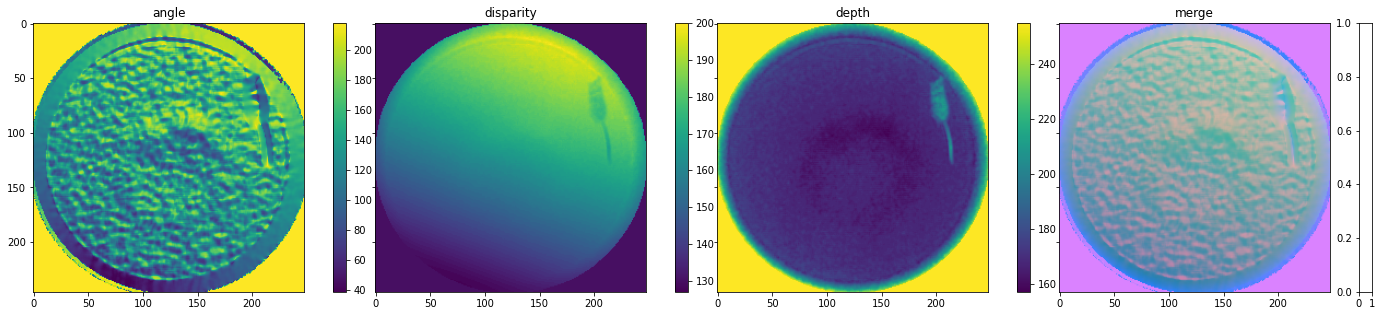

In [6]:
camera_matrix = getCameraParam('depth')
o_impl_hha = getHHA(camera_matrix, raw_frames[0], raw_frames[0])
plot_tri_channel(o_impl_hha, labels=['angle', 'disparity', 'depth', 'merge'])

C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:367: RuntimeWarning: divide by zero encountered in true_divide
  one_Z = np.expand_dims(1 / Z, axis=2)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:368: RuntimeWarning: invalid value encountered in true_divide
  X_Z = np.divide(X, Z)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:369: RuntimeWarning: invalid value encountered in true_divide
  Y_Z = np.divide(Y, Z)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:373: RuntimeWarning: invalid value encountered in true_divide
  X_ZZ = np.expand_dims(np.divide(X, ZZ), axis=2)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:374: RuntimeWarning: invalid value encountered in true_divide
  Y_ZZ = np.expand_dims(np.divide(Y, ZZ), axis=2)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:185: RuntimeWarning: invalid value encountered in multiply
  + np.multiply(AtA_1[:, :, 2], Atb[:, :, 2])
C:\Users\Josh\AppD

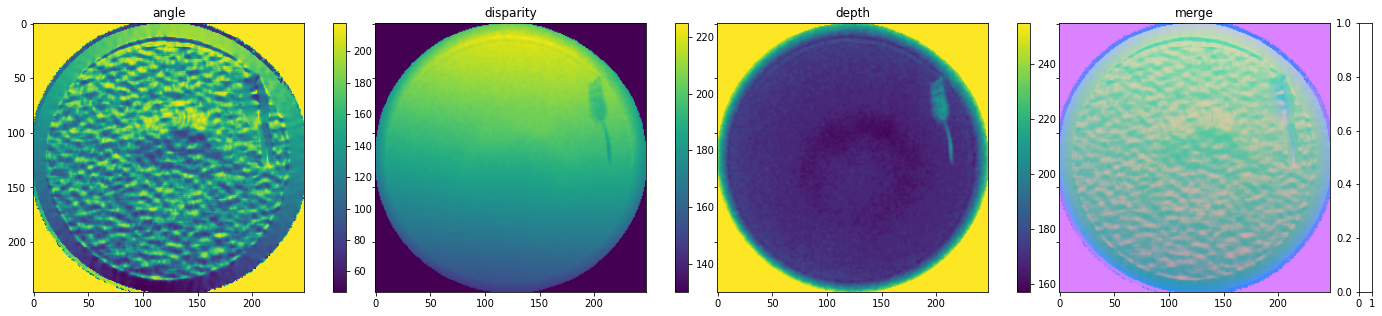

In [7]:
camera_matrix = getCameraParam('depth')
encoder = HHAEncoder(camera_matrix, raw_frames[0])
hha = encoder.encode(raw_frames[0])

plot_tri_channel(hha, labels=['angle', 'disparity', 'depth', 'merge'])

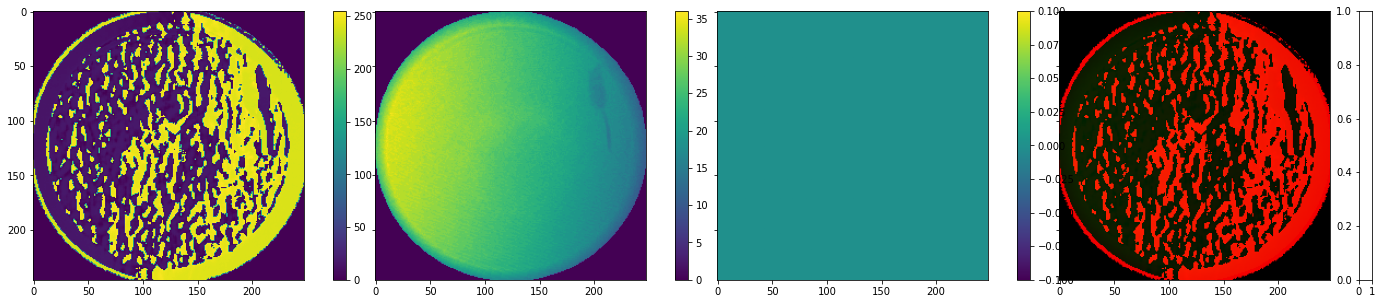

In [8]:
plot_tri_channel(hha - o_impl_hha)


c:\Users\Josh\anaconda3\envs\moseq-detectron\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

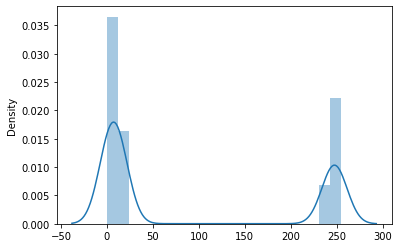

In [9]:
sns.distplot((hha - o_impl_hha)[:,:,0])

C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:395: RuntimeWarning: invalid value encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:397: RuntimeWarning: invalid value encountered in true_divide
  N[:, :, i] = np.divide(N[:, :, i], divide_fac)


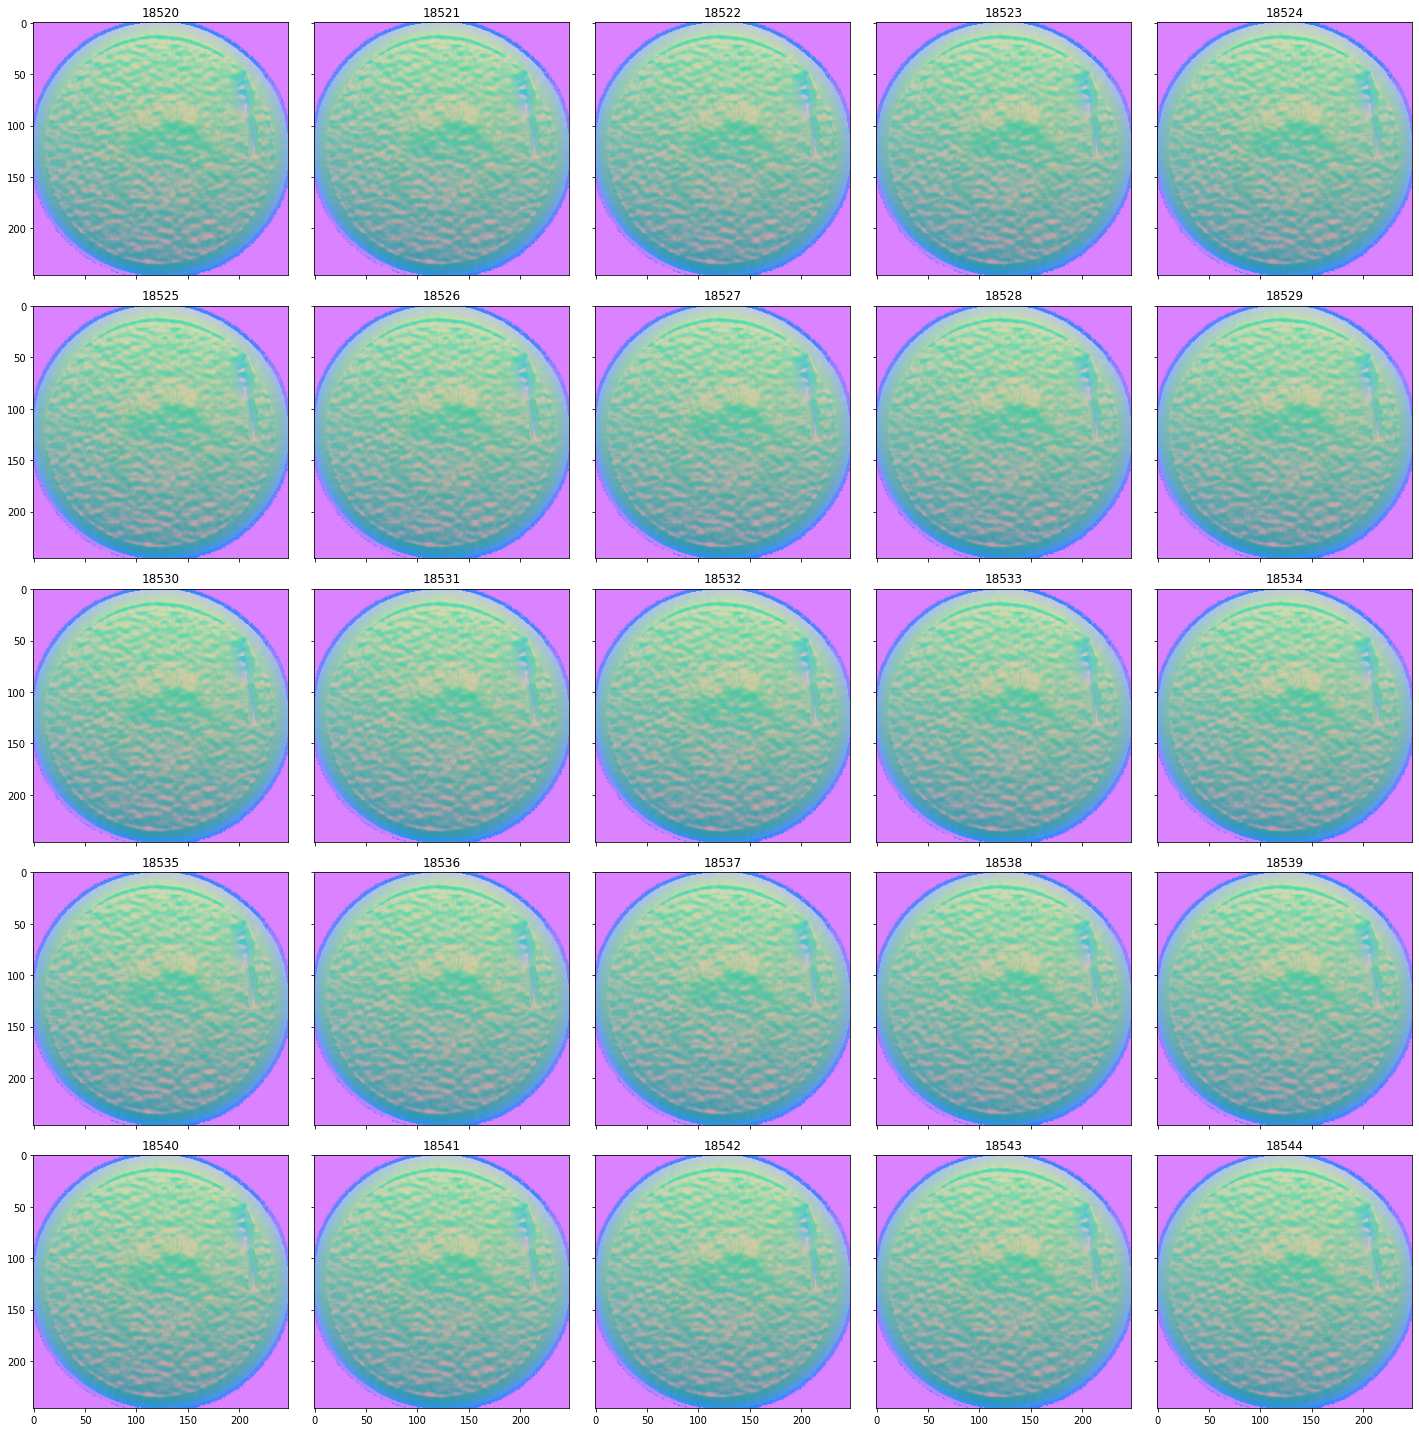

In [10]:
hha_frames = []
for rf in raw_frames:
    hha_frames.append(encoder.encode(raw_frames[0]))

plot_frames(np.array(hha_frames), frame_idxs, vmin=None, vmax=None)


In [11]:
%%timeit -n 100 -r 3
encoder.encode(raw_frames[0])

C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:395: RuntimeWarning: invalid value encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:397: RuntimeWarning: invalid value encountered in true_divide
  N[:, :, i] = np.divide(N[:, :, i], divide_fac)


89.4 ms ± 3.47 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [12]:
%prun encoder.encode(raw_frames[0])

C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:395: RuntimeWarning: invalid value encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
C:\Users\Josh\AppData\Local\Temp/ipykernel_47008/1197631399.py:397: RuntimeWarning: invalid value encountered in true_divide
  N[:, :, i] = np.divide(N[:, :, i], divide_fac)


         1514 function calls (1469 primitive calls) in 0.075 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        9    0.016    0.002    0.016    0.002 {built-in method scipy.ndimage._nd_image.correlate}
        1    0.014    0.014    0.074    0.074 1197631399.py:57(encode)
        1    0.008    0.008    0.035    0.035 1197631399.py:134(filterItChopOff)
        1    0.007    0.007    0.051    0.051 1197631399.py:336(computeNormalsSquareSupport)
       33    0.006    0.000    0.006    0.000 {built-in method numpy.asarray}
   115/70    0.005    0.000    0.017    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.003    0.003    0.060    0.060 1197631399.py:27(_fastProcessDepthImage)
       23    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
        1    0.002    0.002    0.002    0.002 1197631399.py:198(invertIt)
        7    0.002    0.000    0.002

In [13]:
cleaned_frames = clean_frames(raw_frames, iters_tail=3, prefilter_time=(3,))
features, masks = get_frame_features(cleaned_frames, progress_bar=False, use_cc=True, frame_threshold=3)

Cleaning frames: 100%|██████████| 25/25 [00:00<00:00, 1921.49it/s]


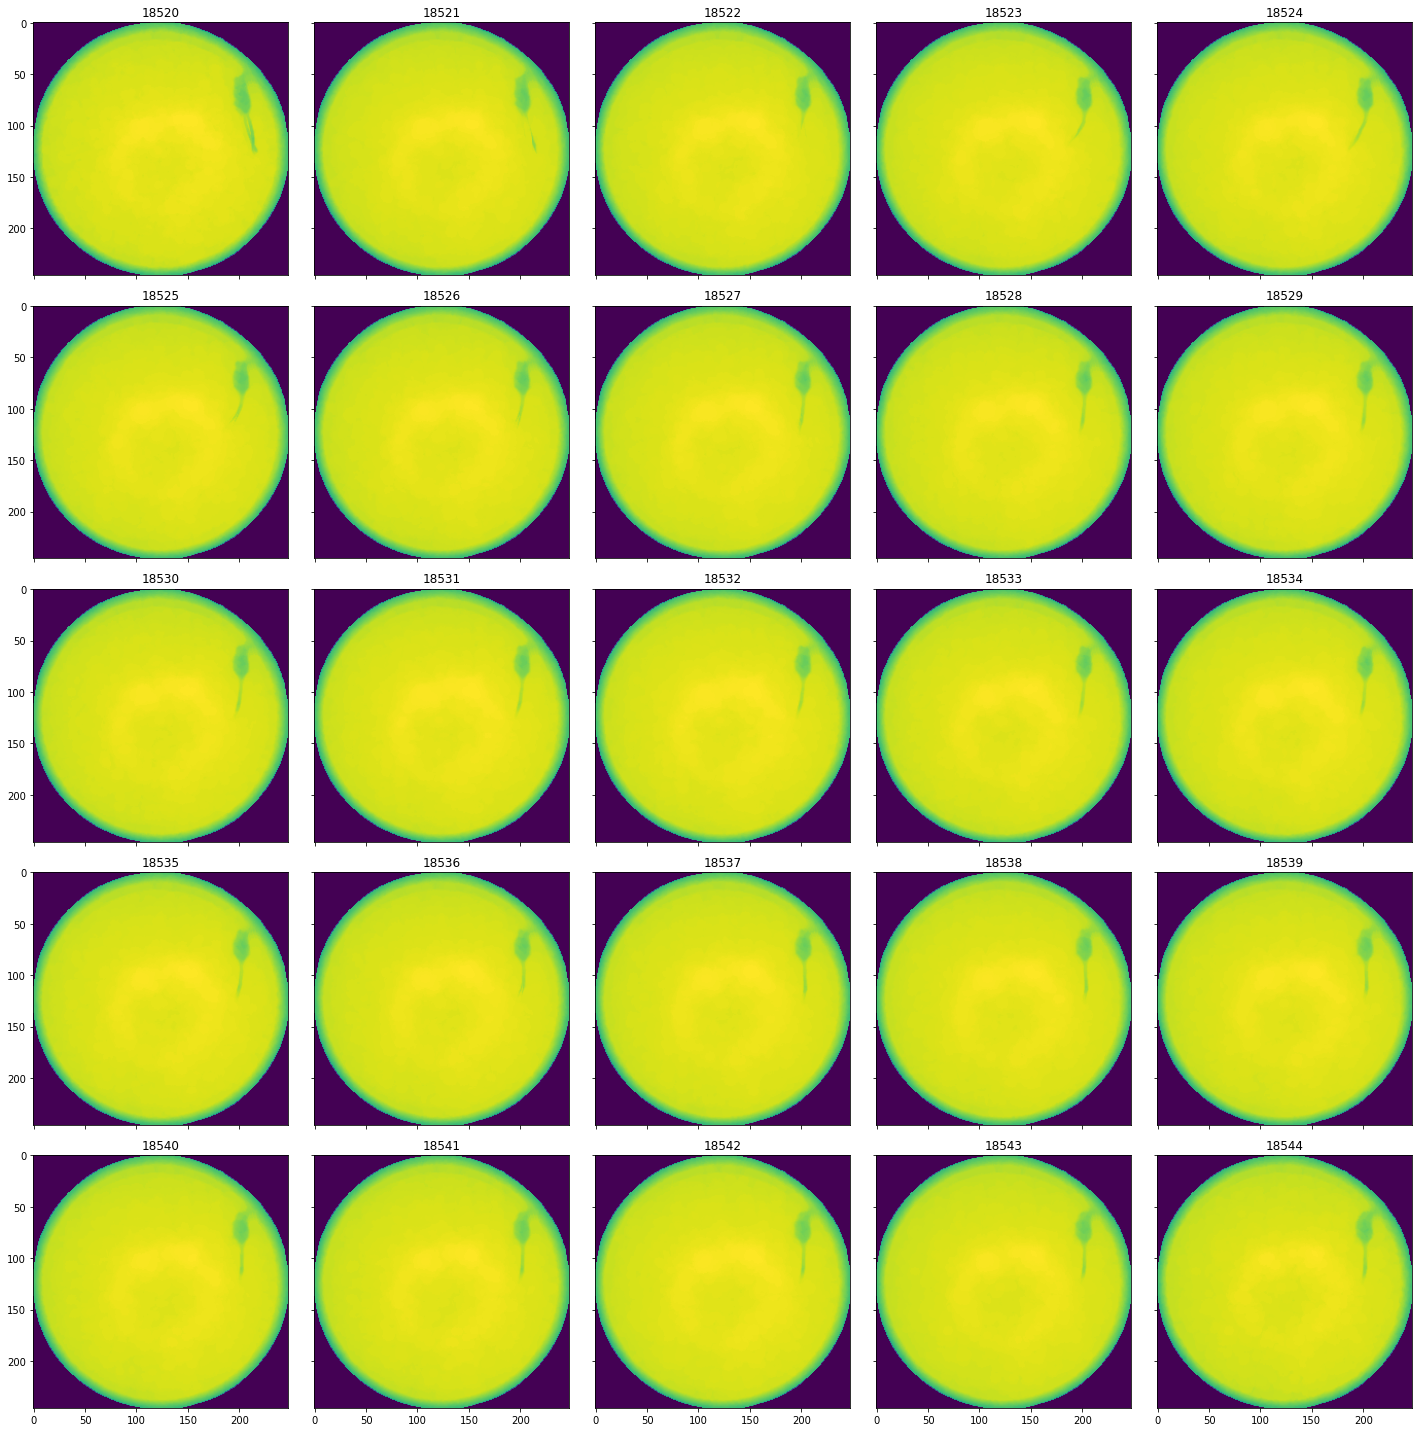

In [14]:
plot_frames(cleaned_frames, frame_idxs, vmin=None, vmax=None)